In [11]:
include("../output.jl")
using ImpvolOutput, CSV, JLD2, FileIO, Plots
gr()
default(fmt = :png)
parameters = load("../experiments/baseline/common_parameters.jld2")["parameters"]

INFO: Precompiling module Logging.
Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] uuid4(::MersenneTwister) at ./deprecated.jl:57
 [3] msg_header at /Users/koren/.julia/v0.6/IJulia/src/msg.jl:18 [inlined]
 [4] msg_pub(::IJulia.Msg, ::String, ::Dict{String,String}, ::Dict{String,Any}) at /Users/koren/.julia/v0.6/IJulia/src/msg.jl:30 (repeats 2 times)
 [5] send_stream(::String) at /Users/koren/.julia/v0.6/IJulia/src/stdio.jl:172
 [6] send_stdio(::String) at /Users/koren/.julia/v0.6/IJulia/src/stdio.jl:130
 [7] (::Base.##302#303{IJulia.#send_stderr,Timer})() at ./event.jl:436
while loading /Users/koren/Google Drive/Research/impvol-julia/output.jl, in expression starting on line 10
19-Apr 12:43:49:INFO:root:Precompiling module GR.
Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] uuid4(::MersenneTwister) at ./deprecated.jl:57
 [3] msg_header at /Users/koren/.julia/v0.6/IJulia/src/msg.jl:18 [inlined]
 [4] msg_pub(::IJulia.Msg, ::String, ::Dict{S

Dict{Symbol,Any} with 45 entries:
  :S_nt                     => [0.0 0.0 … 0.0 0.0]…
  :one_over_rho             => 0.0
  :inner_tolerance          => 0.0002
  :S_nt_data                => [1184.95 -1239.14 … -406.84 1074.1]…
  :eta                      => 4.0
  :S                        => 101
  :sigma                    => 0.999
  :d                        => [0.991383 7.85e-7 … 0.000689 0.0004425; 7.42e-5 …
  :adjustment_tolerance     => 0.0004
  :middle_step_size         => 0.449329
  :A_njs                    => Array{Float64,4}[[1466.01 503.068 … 1568.37 7165…
  :gamma_jk                 => [0.17112 0.273944 … 0.0195213 0.0108426; 0.04826…
  :p_sectoral               => [1.26077 2.37256 … 1.79398 1.0]…
  :B_j                      => [5.5087]…
  :max_iter_adjustment      => 100
  :w_njt                    => [53118.2 20374.8 … 1.48903e5 1.12031e6]…
  :global_sectoral_shock    => [7.02105e-15]…
  :country_shock_njs        => Array{Float64,4}[[-2.70302e-16 -4.55127e-16 … 7.…
  :idi

In [12]:
function load_GDP(scenario)
    if scenario=="data"
        data = load("../data/impvol_data.jld2")
        cpi = CSV.read("../data/cpi.csv")
        us_cpi = reshape(cpi[:,end] ./ cpi[1,end], (1,1,1,36))
        dollar_price_index = data["pwt"] .* us_cpi
        return (sum(data["va"], 3) ./ dollar_price_index)[1,:,1,:]'
    else
        results = load("../experiments/$scenario/results.jld2")["results"]
        return sum(ImpvolOutput.make_series(results, :real_GDP), 3)[1,:,1,:]'
    end
end
function load_import(scenario)
    results = load("../experiments/$scenario/results.jld2")["results"]
    expenditure_mjt = ImpvolOutput.make_series(results, :E_mjs)
    trade_shares_mnjt = ImpvolOutput.make_series(results, :d_mnjs)
    N, _, J, T = size(trade_shares_mnjt)
    # zero out domestic spending so as not to count in imports
    for n=1:N, j=1:J, t=1:T
        trade_shares_mnjt[n,n,j,t] = 0.0
    end
    import_mjt = sum(trade_shares_mnjt, 2) .* expenditure_mjt
    return sum(import_mjt, 3)[:,1,1,:]'
end
function load_expenditure(scenario)
    results = load("../experiments/$scenario/results.jld2")["results"]
    expenditure_mjt = ImpvolOutput.make_series(results, :E_mjs)
    return sum(expenditure_mjt, 3)[:,1,1,:]'
end

load_expenditure (generic function with 1 method)

In [13]:
function compare_trade(scenarios, labels, country)
    country_names = CSV.read("../experiments/baseline/output_table.csv")[:country_names]
    X = zeros(36, length(scenarios))
    if country==0
        name = "World"
    else
        name = country_names[country]
    end
    for s = 1:length(scenarios)
        expenditure = load_expenditure(scenarios[s])
        import_value = load_import(scenarios[s])
        if country==0
            X[:,s] .= (sum(import_value, 2) ./ sum(expenditure, 2) * 100)[:,1]
        else
            X[:,s] .= import_value[:,country] ./ expenditure[:,country] * 100
        end
    end
    plot(1972:2007, X, label=labels, title=name, ylabel="Share of imports in expenditure (percent)")
end

compare_trade (generic function with 1 method)

In [14]:
function compare(scenarios, country, detrend=false)
    country_names = CSV.read("../experiments/baseline/output_table.csv")[:country_names]
    X = zeros(36, length(scenarios))
    if country==0
        name = "World"
    else
        name = country_names[country]
    end
    for s = 1:length(scenarios)
        GDP = log.(load_GDP(scenarios[s]))
        if detrend
          GDP, _ = ImpvolOutput.DetrendUtilities.detrend(GDP',parameters[:bp_weights])
            GDP = GDP'
        end
        if country==0
            X[:,s] .= log.(sum(exp.(GDP), 2)[:,1])
        else
            X[:,s] .= GDP[:,country]
        end
        println(var(X[:,s]))
    end
    plot(X, label=scenarios, title=name)
end

compare (generic function with 2 methods)

In [15]:
compare_trade(["baseline/actual", "baseline/kappa1972"], ["Baseline", "Constant trade cost"], 0)
savefig("../trade_share.pdf")

In [5]:
for j=1:parameters[:N]
    compare(["baseline/kappa1972", "fixed_trade/actual"], j, true)
    savefig("$j.pdf")
end

0.0009225061447556209
0.0009594295139793008
0.0009482287939496818
0.00016196763833814198
0.0030141337472776603
0.0003271951787977665
0.0021928248040594222
0.0002762413844013028
0.006155142413153407
0.005989672672680946
0.0019540304771959427
0.0008145027887873705
0.0020092484139835223
0.0002815244162215354
0.000996266875388787
0.00047729004843412174
0.0002627825838306647
0.00020186605643555228
0.0005211679769600927
0.00020719408639580266
0.00038298902913659876
0.00032932818768090444
0.0012171115771111595
0.0008308149209191414
0.0025548045880616397
0.0005823585563834424
0.00026319856348793076
0.00017946138052036563
0.00030535882173507407
0.00023900985609919253
0.002429502228077559
0.0010030781190242415
0.0012414812235079392
0.00019358153060702228
0.0012563936457545136
0.0006613754478724205
0.001664499204642059
0.0011660559344255142
0.0016313234722727503
0.0016840269954811959
0.0008638468762395069
0.0008709205475042106
0.0012375397189963487
0.00017896283137671252
0.0005923279529931927
0.0

0.0007928906818515105
0.003917854569878482
0.

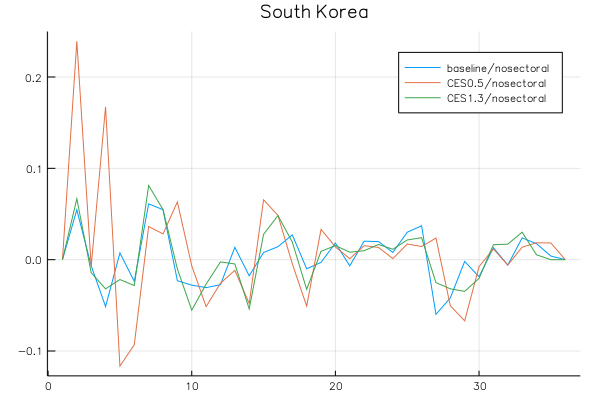

0009827231506166908


In [18]:
compare(["baseline/nosectoral", "CES0.5/nosectoral", "CES1.3/nosectoral"], 21, true)

0.0027154587008125296
0.0014140187210188654


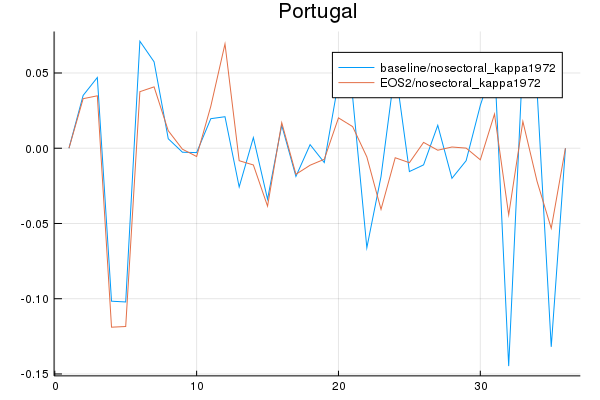

In [104]:
compare(["baseline/nosectoral_kappa1972", "EOS2/nosectoral_kappa1972"], 19, true)

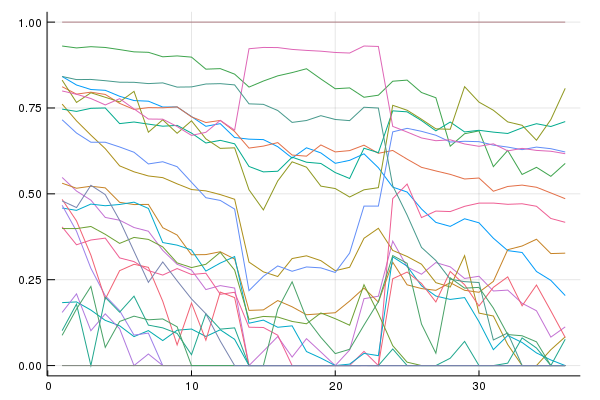

In [75]:
plot(parameters[:d][3,3,:,:]', label="")

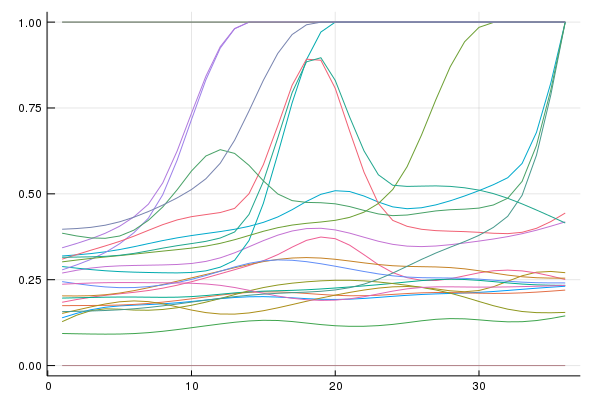

In [79]:
plot(parameters[:kappa_mnjt][3,end,:,:]', label="")

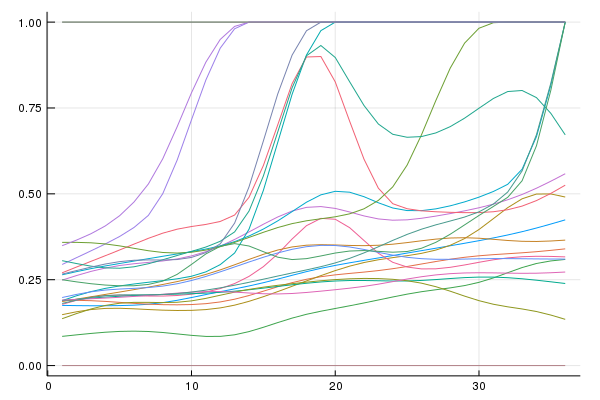

In [85]:
plot(parameters[:kappa_mnjt][3,22,:,:]', label="")

In [61]:
BEL_import = sum(BEL_shares, 1)

1×24 Array{Float64,2}:
 0.158444  0.188094  0.0696155  0.452242  …  1.29409  0.912001  0.520593  0.0

In [62]:
domestic_per_import = 1./BEL_import - 1

1×24 Array{Float64,2}:
 5.31137  4.31648  13.3646  1.2112  …  -0.227256  0.0964904  0.920887  Inf

In [87]:
country_shock = parameters[:country_shock][1,:,1,:]'

36×25 Array{Float64,2}:
 -1.18826e-16  -3.781e-16    -2.68917e-16  …   3.01573e-16   1.25796e-15
  0.000684231  -0.028371      0.0106188        0.025693      0.0274939  
 -0.0179036    -0.0197972    -0.00349749       0.0139659     0.0140506  
 -0.0100593    -0.00798006   -0.000215316     -0.00798642   -0.0108118  
 -0.00777268    0.00853693    0.0149319        0.00408703   -0.00960562 
 -0.000993319   0.00579023   -0.00251478   …  -0.00345103   -0.0337811  
 -0.0139966    -0.0130964    -0.00167385       0.00939622    0.0319579  
  0.0109514    -0.00128628    0.00209395       0.00504421    0.0190867  
  0.00792892    0.00525648    0.00870062      -0.0173433     0.00606739 
 -0.00273465    0.00702931   -0.0136135       -0.0127049     0.00101907 
  0.00331759    0.00111902    0.0175009    …   0.000783284  -0.0180051  
 -0.0166906     0.0164857     0.0117222        0.0155913    -0.00260961 
 -0.00171225   -0.00223119    0.0148404       -0.0017838     0.000366927
  ⋮                        

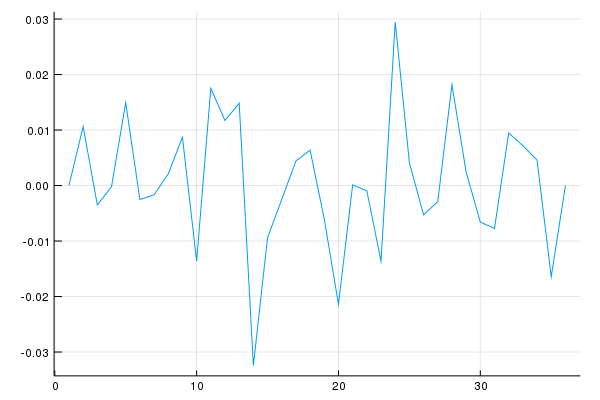

In [88]:
plot(country_shock[:,3], label="")